## Goal:

##### 1. This project is going to predict the number of points based on wine reviews:
    
      f: X -> y
*   X will be the input reviews
*   y will be value of points


##### 2. And construct a small recommendation system to recommend 5 wineries for a customer.
---

## Roadmap:

##### 1. Import data: this project is done on Google Colab, I save the raw dataset downloaded from Kaggle website on Google Drive and then import it to Google Colab.

##### 2. Data exploration: 

*   Overall dataset analysis: check number of missing values, data type of each features;
*   Numerical features: descriptive stats, distribution, correlation analysis;
*   Categorical features: unique value, distribution analysis.

##### 3. Data preprocessing:

*   Missing data imputation;
*   Drop columns;
*   Categorical features: convert long sentences feature to its length, One-hot encoding;
*   Reduce dimensionality: PCA.

##### 4. Model training and validation:

*   KNN: 5-fold cross validation, tuning parameter K;
*   CatBoost: feature importance discussion, reduce data dimensionality by dropping unimportant features;

##### 5. Small recommendation system -- colaborative filtering:
*   Cosine similarity calculation: KNN.
---
## Results
*   KNN model regression analysis: when k = 30, the RMSE of testing data is 2.112;
*   CatBoost model: the RMSE of testing data is 1.844, and after dropping unimportant features, the RMSE of testing data is 1.868 (doesn't change much);
*   KNN recommendation system: this model only works on customers who have already reviewed on any wines, but doesn't work on new customers.








# Part 0: Setup Google Drive Environment

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1JU1ROzMJktzwvgdbajW0HZMEFzKi8ZDI'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) 
file.GetContentFile('winemag-data_first150k.csv')

# Part 1: Data Exploration

### Part 1.1: Understand the Raw Dataset

In [0]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import imblearn
# will show all the columns
pd.set_option('display.max_columns', None)

wine_df = pd.read_csv('winemag-data_first150k.csv')

In [0]:
wine_df = wine_df.drop('Unnamed: 0', axis = 1)
wine_df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [0]:
print ("Num of rows: " + str(wine_df.shape[0])) # row count
print ("Num of columns: " + str(wine_df.shape[1])) # col count

Num of rows: 129971
Num of columns: 13


In [0]:
wine_df.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

Some columns contain missing values, let's see the number of non-missing values in each column:

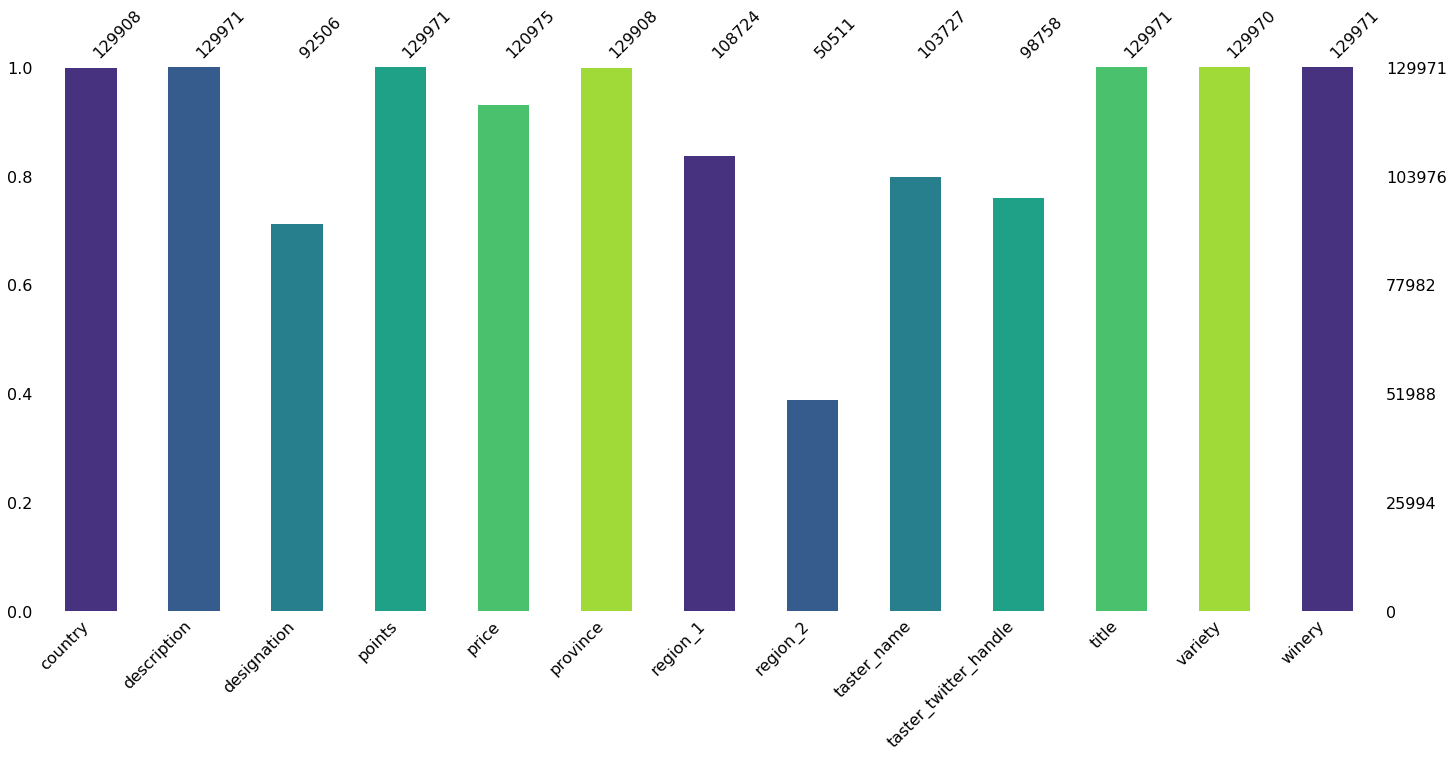

In [0]:
# Some columns contain missing values, let's see the number of non-missing values in each column:
wine_df.describe(include='all',).T
import missingno as msno
import seaborn as sns
msno.bar(wine_df,color= sns.color_palette('viridis'))# missing values

## Part 1.2 Understand the Features 
### Part 1.2.1 Descriptive Statistics of Numeric Features



In [0]:
wine_df.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


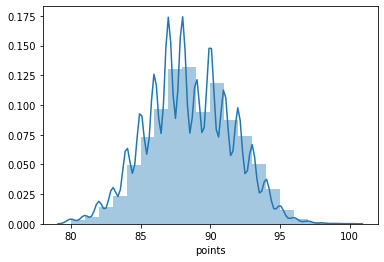

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Check distribution of 'points':
sns.distplot(wine_df['points'], bins = 20)

The range of points is in [80, 100],most of the wines have points less than 90.

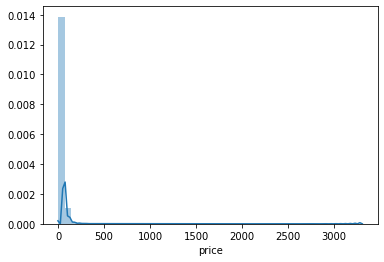

In [0]:
# Distribution of 'price':
sns.distplot(wine_df['price'].dropna())

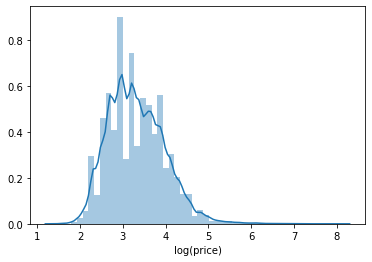

In [0]:
# Distribution of log transformed 'price'
ax = sns.distplot(np.log(wine_df['price']).dropna())
ax.set(xlabel = 'log(price)')
plt.show()

 The range of 'price' is in [4, 3300], however, only a small number of wines have price higher than 45. After log trasformation, the distribution seems closer to normal distribution.

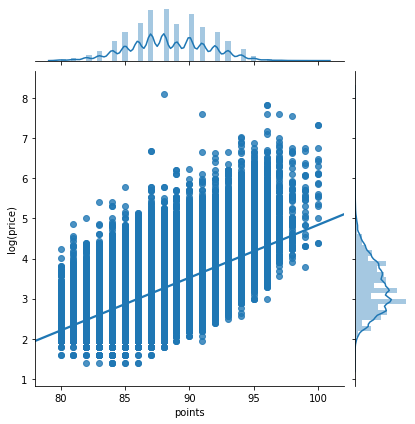

In [0]:
# Correlation between 'points' and 'log(price)':
df_plot = pd.DataFrame(data={'points': wine_df['points'], 'log(price)': np.log(wine_df['price'])})
sns.jointplot(x = 'points', y = 'log(price)', data = df_plot, kind = 'reg');

Generally speaking, expensive wines tend to have higher points.


### Part 1.2.2 Distribution of Categorical Features
1. Check number of unique values in each column

In [0]:
wine_df.nunique()

country                      43
description              119955
designation               37979
points                       21
price                       390
province                    425
region_1                   1229
region_2                     17
taster_name                  19
taster_twitter_handle        15
title                    118840
variety                     707
winery                    16757
dtype: int64

'description' and 'title' columns have more than 91% unique values which are not informative. Thus I remove them in data preprocessing part later.

2. Due to limited space, only some of the categorical variables are displayed here. I use barplot to display the top 20 frequent values for each variable.

Text(0.5, 0, 'country')

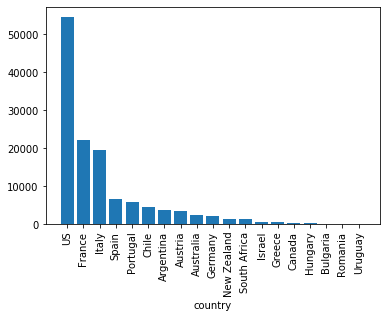

In [0]:
plt.bar(x = wine_df['country'].value_counts()[0:19].index, height = wine_df['country'].value_counts()[0:19].values)
plt.xticks(rotation=90)
plt.xlabel('country')

US, France and Italy are the three main countries where the wines come from.

Text(0.5, 0, 'variety')

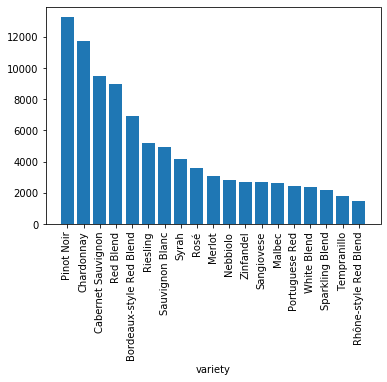

In [0]:
plt.bar(x = wine_df['variety'].value_counts()[0:19].index, height = wine_df['variety'].value_counts()[0:19].values)
plt.xticks(rotation=90)
plt.xlabel('variety')

Pinot Noir is the most popular variety, and chrdonnay is the second popular one.

Text(0.5, 0, 'winery')

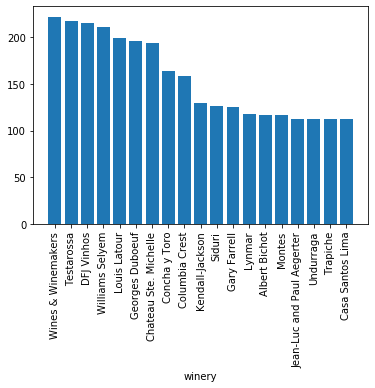

In [0]:
plt.bar(x = wine_df['winery'].value_counts()[0:19].index, height = wine_df['winery'].value_counts()[0:19].values)
plt.xticks(rotation=90)
plt.xlabel('winery')

There are many unique values in column 'winery', most of them occur less than 200 times. Thus this is not a very informative column.

### Part 1.2.3 Descriptive Statistics of a Special Column: 'description'

I tend to convert description column to its length (a new numeric column) in Part 1.2.3, before doing that, let's analyze if there is any correlation between length of descriptions and points.

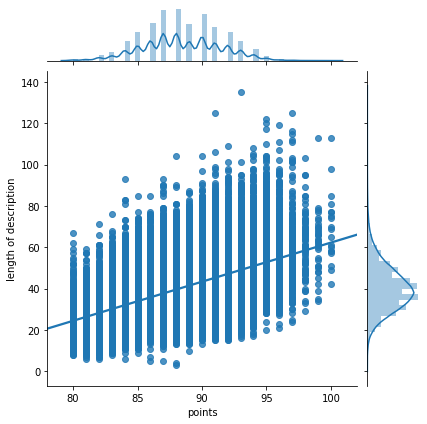

In [0]:
description_to_plot = wine_df['description'].apply(lambda x: len(x.split()))
desription_plot = pd.DataFrame(data={'points': wine_df['points'], 'length of description': description_to_plot})
sns.jointplot(x = 'points', y = 'length of description', data = desription_plot, kind = 'reg');

# Part 2 Data Preprocessing
I preprocess **2** groups of data ([X, y] and [X2, y2]):
1. The first group of data [X, y] is for **KNN** model training. Generally speaking, I perform One-Hot Encoding on categorical variables and then apply Principle Component Analysis on that high dimensional data.
2. Another group of data [X2, y2] is for the second model. Because this dataset contains a lot of categorical variables, the second model I choose is **Catboost**, which is a utility model relates to a gradient lifting algorithm library, and can deal with class type features well.

## Part 2.1 Preprocess Data for KNN Model
### Part 2.1.1 Drop Columns

Remove the first index column and columns 'designation', 'region_2', 'taster_name', 'taster_twitter_handle' which have more than 20% missing values.
Also, remove 'title' and 'description' columns which have more than 91% unique values.

In [0]:
wine_prep = wine_df
to_drop = ['designation','region_2','taster_name','taster_twitter_handle', 'title', 'description']
wine_prep = wine_prep.drop(to_drop, axis=1)

### Part 2.1.2 Preprocess Numeric Features
1. replacing missing values in column 'points' and 'price'.

In [0]:
wine_prep['points'] = (wine_prep['points'].fillna(wine_df['points'].mean())).astype('int64')
wine_prep['price'] = (wine_prep['price'].fillna((wine_df['price'].mean()))).astype('float64')
wine_prep.head()

,country,points,price,province,region_1,variety,winery
0,Italy,87,35.363389,Sicily & Sardinia,Etna,White Blend,Nicosia
1,Portugal,87,15.000000,Douro,NaN,Portuguese Red,Quinta dos Avidagos
2,US,87,14.000000,Oregon,Willamette Valley,Pinot Gris,Rainstorm
3,US,87,13.000000,Michigan,Lake Michigan Shore,Riesling,St. Julian
4,US,87,65.000000,Oregon,Willamette Valley,Pinot Noir,Sweet Cheeks


### Part 2.1.3 Preprocess Categorical Features

1. replacing values that don't appear frequently with 'others' 
2. applying One-Hot Encoding on categorical features
3. applying PCA on features to reduce feature dimension

In [0]:
# Replace non-frequent values with 'Others':
def others(x):
  to_replace = x.value_counts().index[(x.value_counts() < 100)]
  x[x.apply(lambda x_1: x_1 in to_replace)] = 'Others'
  return x
enc_cols = wine_prep.drop(['price', 'points'], axis = 1)
enc_cols = enc_cols.apply(others)

# One-Hot encoding:
dummies = pd.get_dummies(enc_cols) 

# Combined with 'price':
wine_encoded = pd.concat([wine_prep['price'], dummies], axis = 1)

### Part 2.1.4 Replace Feature 'description' with Its Length

In [0]:
description_len = wine_df['description'].apply(lambda x: len(x.split()))
wine_encoded = pd.concat([wine_encoded, description_len], axis = 1)

### Part 2.1.5 Principal Component Analysis 

Because the dimension of encoded dataset for KNN model is very high, the training speed will be slow. After applying PCA method, the final training dataset contains 50 features.

In [0]:
from sklearn import decomposition

X = wine_encoded
y = wine_df['points']

# PCA
pca = decomposition.PCA(n_components=50)
pca.fit(X)
X = pca.transform(X)
print('The dimension of the first training dataset is:')
X.shape

The dimension of the first training dataset is:


(129971, 50)

## Part 2.2 Preprocess Data for Catboost

In [0]:
wine_prep2 = wine_df
y2 = (wine_prep2['points'].fillna(wine_df['points'].mean())).astype('int64')
wine_prep2['price'] = (wine_prep2['price'].fillna((wine_df['price'].mean()))).astype('float64')
to_drop = ['description', 'points']
wine_prep2 = wine_prep2.drop(to_drop, axis=1)
X2 = pd.concat([wine_prep2, description_len], axis = 1)
X2=X2.fillna(-1)
print('The dimension of the second training dataset is:')
X2.shape

The dimension of the second training dataset is:


(129971, 12)

# Part 3: Regression Model Analysis
## Part 3.1 K-Nearest Neighbors
### Part 3.1.1 Split Dataset

In [0]:
# Split data into training and testing
from sklearn import model_selection

# Reserve 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

print('training data has %d observation with %d features'% X_train.shape)
print('test data has %d observation with %d features'% X_test.shape)

training data has 103976 observation with 50 features
test data has 25995 observation with 50 features


### Part 3.1.2 Model Training and Validation

In [0]:
# Build model
from sklearn.neighbors import KNeighborsRegressor

# K Nearest Neighbors
regressor_KNN = KNeighborsRegressor()


Use 5-fold Cross Validation to get the mean squared error for KNN:

In [0]:
# Use 5-fold Cross Validation to get the mean squared error for different models
model_names = ['KNN']
model_list = [regressor_KNN]
count = 0

for regressor in model_list:
  cv_score = model_selection.cross_val_score(regressor, X, y, cv=5, scoring='neg_mean_squared_error')
  cv_score = np.sqrt(-cv_score)
  print(cv_score)
  print('Model RMSE of %s is: %.3f'%(model_names[count], cv_score.mean()))

[2.21111219 2.22051193 2.14503297 2.2102439  2.2033381 ]
Model RMSE of KNN is: 2.198


## Part 3.2 Tuning Model Parameters for KNN

Change the number of neighbors in the KNN model (I don't use cross validation here because it takes very long time to run):



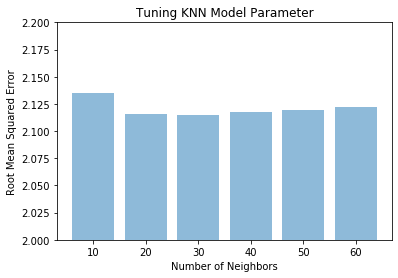

When k = 30, KNN model has the best estimation with root mean squared error = 2.115


In [0]:
# change the number of neighbors (10, 20, 30, 40, 50, 60) in the KNN model
from sklearn.metrics import mean_squared_error
rmse_KNN = []
for n in [10, 20, 30, 40, 50, 60]:
  regressor_KNN = KNeighborsRegressor(n_neighbors = n)
  regressor_KNN.fit(X_train, y_train)
  y_predict_KNN = regressor_KNN.predict(X_test)
  rmse_KNN.append((mean_squared_error(y_test, y_predict_KNN))**0.5)

import matplotlib.pyplot as plt
plt.bar(np.arange(6), rmse_KNN, align='center', alpha=0.5)
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Number of Neighbors')
plt.title('Tuning KNN Model Parameter')
plt.xticks(np.arange(6), [10, 20, 30, 40, 50, 60])
axes = plt.gca()
axes.set_ylim([2.0, 2.2])
plt.show()
print('When k = 30, KNN model has the best estimation with root mean squared error = %.3f' % min(rmse_KNN) )

## Part 3.3 CatBoost
Cat Boost has two advantages:
1. Firstly, it deals with categorical features in the training process rather than in the pre-processing stage. 
2. Secondly, the algorithm for calculating leaf nodes can avoid overfitting when choosing tree structure.

### Part 3.3.1 Split Dataset


In [0]:
categorical_features_indices =[0,1,3,4,5,6,7,8,9,10]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, 
                                                    random_state=42)

X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_train2, y_train2, test_size=0.2, 
                                                    random_state=52)

### Part 3.3.2 Cat Boost Model Training and Testing

In [0]:
def perform_model(X_train, y_train, X_valid, y_valid, X_test, y_test):
    model = CatBoostRegressor(
        random_seed = 400,
        loss_function = 'RMSE',
        iterations=400,
    )
    
    model.fit(
        X_train, y_train,
        cat_features = categorical_features_indices,
        eval_set=(X_valid, y_valid),
        verbose=False
    )

    y_train_pred = model.predict(X_train)
    rmse_train = (np.mean((y_train - y_train_pred) **2)) **0.5

    y_test_pred = model.predict(X_test)
    rmse_test = (np.mean((y_test - y_test_pred) **2)) **0.5

    print("RMSE on training data: ", rmse_train)
    print("RMSE on test data: ", rmse_test)
    
    return model

In [0]:
model=perform_model(X_train2, y_train2, X_valid2, y_valid2, X_test2, y_test2)

RMSE on training data:  1.535566132453336
RMSE on test data:  1.8444138832320554


## Part 3.4 CatBoost Feature Importance Discussion

In [0]:
feature_score = pd.DataFrame(list(zip(X2.dtypes.index, model.get_feature_importance(Pool(X2, label=y2, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

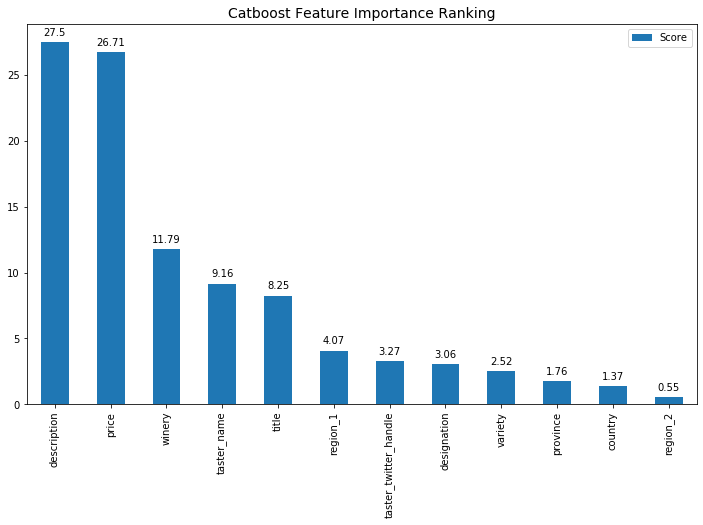

In [0]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

As we can see from the feature importance plot, features 'region_2', 'country', 'province' and 'variety' are not important to CatBoost Model. Dropping those columns could decreasing training time. Let's try to drop them and see how the score changes:

In [0]:
X2=X2.drop(columns=['country', 'province', 'region_2', 'variety'])

categorical_features_indices =[0,2,3,4,5,6]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, 
                                                    random_state=42)

X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_train2, y_train2, test_size=0.2, 
                                                    random_state=52)

In [0]:
model=perform_model(X_train2, y_train2, X_valid2, y_valid2, X_test2, y_test2)

RMSE on training data:  1.5256643813745259
RMSE on test data:  1.8679501819819297


The RMSE of the model after I drop 4 columns which are not important doesn't change a lot. It's feasible to drop those columns to improve model efficiency.

# Part 4: Small Recommendation System -- Collabrative Filtering
This small recommendation system is performed by KNN, the similarity between each pair of customers is represented by cosine similarity.
For a customer, I would like to recommend 5 wineries which are similar to the one the customer has reviewed. And those recommended wineries were tasted by 5 other customers who gave points higher than the average:

## Part 4.1 Data Preprocessing



In [0]:
# filter the dataframe, only keep rows which satisfy the condition: 'pinot noir', 'price less than 20 dollars', 'has a fruity taste' and 'points > average'
def func(x):
  if 'fruity' in x:
    return True
  return False

X_re = pd.DataFrame(X[(wine_df['variety'] == 'Pinot Noir') & (wine_df['price'] < 20) & (wine_df['description'].apply(func)) & (wine_df['points'] > wine_df['points'].mean())])
y_re = pd.DataFrame(y[(wine_df['variety'] == 'Pinot Noir') & (wine_df['price'] < 20) & (wine_df['description'].apply(func)) & (wine_df['points'] > wine_df['points'].mean())]).reset_index(drop = True)
wine_re = wine_df[(wine_df['variety'] == 'Pinot Noir') & (wine_df['price'] < 20) & (wine_df['description'].apply(func)) & (wine_df['points'] > wine_df['points'].mean())]
wine_re_train = pd.concat([X_re, y_re], axis = 1)

## Part 4.2 Model Training and Recommendation

In [0]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

knn = NearestNeighbors(n_neighbors=10,algorithm= 'brute', metric= 'cosine')
model_knn = knn.fit(wine_re_train)

I randomly select a customer from raw dataset 'wine_df', and try to give him/her recommendation from the model.

In [0]:
import random
for i in range(2):
  query_index = np.random.choice(pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis = 1).shape[0])
  distance, indice = model_knn.kneighbors(pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis = 1).iloc[query_index,:].values.reshape(1, -1),n_neighbors= 6)
  for i in range(0, len(distance.flatten())):
      if  i == 0:
          print('Recmmendation for customer {0} in dataset row {1}:\n'.format(wine_df.iloc[query_index, 8],pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis = 1).index[query_index]))
      else:
          print('{0}: {1} with distance: {2}'.format(i, wine_re.iloc[indice.flatten()[i], 12], distance.flatten()[i]))
      

Recmmendation for customer nan in dataset row 13883:

1: Dr. Nägler with distance: 0.011897025262433969
2: J. Lohr with distance: 0.015233030969037276
3: Willm with distance: 0.01562148796809526
4: Balletto with distance: 0.015658968179223076
5: Villa Wolf with distance: 0.015929275688086997
Recmmendation for customer Kerin O’Keefe in dataset row 51837:

1: Willm with distance: 0.00042388708821594623
2: J. Lohr with distance: 0.0007977300452143288
3: Three Brothers with distance: 0.0011844567231310554
4: Dr. Nägler with distance: 0.0012684173846814195
5: Murphy-Goode with distance: 0.0014919488310070061
Recmmendation for customer Lauren Buzzeo in dataset row 12932:

1: Willm with distance: 0.009167540030077137
2: Balletto with distance: 0.009586663853631494
3: J. Lohr with distance: 0.013522808583615209
4: Dr. Nägler with distance: 0.01485081544373379
5: Three Brothers with distance: 0.015207288103780137
Recmmendation for customer Roger Voss in dataset row 83166:

1: Wakefield with dis

This model could give a simple recommendation for a customer who has reviewed for any wines before. The model calculate the similarity between his/her review and other customers' reviews. This is not 'new-customer-friendly' because if a customer hasn't reviewed yet, the model won't work. 